In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

# Harmonic well

In [2]:
from uibcdf_test_systems import HarmonicWell
from uibcdf_test_systems.simulation import langevin_NVT
from uibcdf_test_systems.analysis import get_probability_density

\begin{equation}
P(x)=\frac{1}{Z_{x}} e^{-\frac{kx^{2}}{2k_{B}T}}
\end{equation}

\begin{equation}
Z_{x} = \int_{-\infty}^{\infty} e^{-\frac{kx^{2}}{2k_{B}T}} dx = \sqrt{\frac{2\pi k_{B}T}{k}} 
\end{equation}

Ya que la integral gaussiana es soluble analíticamente:

\begin{equation}
\int_{-\infty}^{\infty} e^{-a x^{2}} dx = \sqrt{\frac{\pi}{a}} 
\end{equation}

Así que:

\begin{equation}
P(x)=\sqrt{\frac{k}{2\pi k_{B}T}} e^{-\frac{kx^{2}}{2k_{B}T}}
\end{equation}

Podemos calcular la posición promedio:

\begin{equation}
\langle x \rangle = \int_{-\infty}^{\infty} x P(x)dx =
\sqrt{\frac{k}{2\pi k_{B}T}} \int_{-\infty}^{\infty} x e^{-\frac{kx^{2}}{2k_{B}T}} dx = 0
\end{equation}

Porque la integral de un momento impar de la distribución gaussiana es $0$:

\begin{equation}
\int_{-\infty}^{\infty} x^{n} e^{-a x^{2}} dx = 0 \hspace{20pt} n=1,3,5,\dots
\end{equation}

Y por último, con ayuda de la integral del segundo momento de la distribución gaussiana,

\begin{equation}
\int_{-\infty}^{\infty} x^{2} e^{-a x^{2}} dx = \frac{\pi^{1/2}}{2a^{3/2}} 
\end{equation}

podemos calcular la desviación cuadrática estandard:

\begin{equation}
\sigma^{2} = \langle \left(\langle x \rangle- x \right)^{2} \rangle =
\int_{-\infty}^{\infty} {x^{2} P(x)dx} = 
\sqrt{\frac{k}{2\pi k_{B}T}} \int_{-\infty}^{\infty} x^{2} e^{-\frac{kx^{2}}{2k_{B}T}} dx =
\frac{k^{1/2}}{\pi^{1/2}(2k_{B}T)^{1/2}} \frac{(2k_{B}T)^{3/2}\pi^{1/2}}{2k^{3/2}} =
\frac{k_{B}T}{k} 
\end{equation}

Ya vemos entonces que la energía potencial promedio de un oscilador armónico es:

\begin{equation}
<U(x)> = \frac{1}{2}k<x^{2}> = \frac{1}{2} k_{B}T
\end{equation}

Y dado que sabemos que la energía cinética promedio es también:

\begin{equation}
<K(v_{x})> = \frac{1}{2}m<v^{2}> = \frac{1}{2} k_{B}T
\end{equation}

La energía total promedio de un oscilador unidimensional es:

\begin{equation}
<U(x) + K(v_{x})> = k_{B}T
\end{equation}

Veamos si la predicción teórica corresponde a lo observado en una dinámica de langevin:

Supongamos que tenemos una partícula de masa $m$ en un potencial de tipo pozo armónico:

In [7]:
mass = (12.0*unit.amu *  16.0*unit.amu)/(12.0*unit.amu + 16.0*unit.amu) # Masa reducida de la molécula diatómica CO

Aunque trabajaremos con una única dimensión, con la dimensión $X$, la simulación la vamos a hacer en tres dimensiones mediante el uso de OpenMM. Como veremos más adelante, es equivalente un sistema unidimensional de pozo armónico que observar únicamente una dimensión en el caso tridimensional. Esto sucede porque el hamiltoniano, la energía, puede descomponerse en dos sumandos: uno que únicamente depende de $x$ y otro que sólo es función de $y$ y $z$.

Por ahora, definamos un potencial tridimensional de tipo armónico para que la partícula quede confinada en una región del espacio tridimensional:

## El potencial armónico en $X$, $Y$ y $Z$.

El potencial armónico con el que vamos a trabajar es isométrico, dado que la forma de la parábola es la misma en las tres dimensiones, centrado en $x=0$, $y=0$ y $z=0$:

\begin{equation*}
V(x,y,z) = \frac{1}{2} k (x^{2}+y^{2}+z^{2})
\end{equation*}

donde $k$ es da cuenta de la apertura de los brazos de la parábola. Más cerrados cuanto mayor es el valor de $k$. O visto de otra manera, la fuerza que describe este potencial es conocida como la ley de hook. Una fuerza tipo muelle en la que su magnitud es mayor conforme más nos alejamos de la posición de equilibrio, y su sentido es siempre el de llevar la partícula hacia dicha posición de equilibrio. Así $k$ es la constante de rigidez, o constante elástica, de un muelle:

\begin{equation*}
\vec{F}(x,y,z) = - \vec{\nabla} V(x,y,z) = 
- \frac{\delta V(x,y,z)}{\delta x} \hat{x} - \frac{\delta V(x,y,z)}{\delta y} \hat{y} - \frac{\delta V(x,y,z)}{\delta z} \hat{z} =
- k\vec{x}-k\vec{y}-k\vec{z}
\end{equation*}


Démosle valor a la constante $k$ del muelle:

In [12]:
k=20.0 * unit.kilocalories_per_mole/ unit.nanometers**2

Y veamos la representación grafica del potencial en cualquiera de los tres ejes con ayuda de una serie de valores de coordenadas, $x$ por ejemplo, y sus correspondientes valores de contribución al potencial total:

In [13]:
def potencial_armonico(x,k):
    return 0.5*k*x**2

In [18]:
x_serie = np.arange(-5., 5., 0.05) * unit.nanometers
Vx_serie = potencial_armonico(x_serie, k)

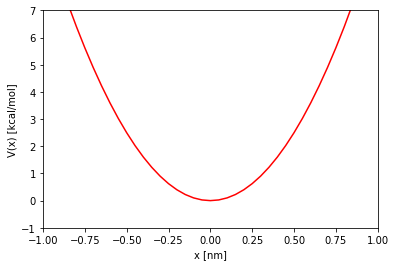

In [19]:
plt.plot(x_serie, Vx_serie, 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("x [{}]".format(x_serie.unit.get_symbol()))
plt.ylabel("V(x) [{}]".format(Vx_serie.unit.get_symbol()))
plt.rcParams['figure.figsize'] = 6,4
plt.show()